# Sensitivity analysis for a geothermal doublet
### Analytical solution combining Schulz (1987) and Charbeneau 

This notebook applies the analytical solution combined of Schulz (1987) and Charbeneau (2000) for the breakthrough curve of a geothermal doublet.

### Sensitivity of breakthrough time

This section performs a variance-based sensitivity analysis using Sobol indices (estimated via Latin Hypercube Sampling) to identify which input parameters (aquifer thickness, well spacing, flow rate, porosity, and thermal properties) have the strongest influence on the thermal breakthrough time. First-order Sobol indices ($S_i$) quantify the direct effect of each parameter, while total-effect indices ($S_T$) capture both direct effects and interactions with other parameters. This analysis helps prioritize which parameters require precise characterization for reliable system predictions.

### Sensitivity analysis for breakthrough curve

This section performs a comprehensive uncertainty quantification of the entire thermal breakthrough curve using Latin Hypercube Sampling (LHS). Unlike the previous analysis that focused on a single scalar output (breakthrough time), this analysis evaluates how the combined parameter uncertainties propagate through the complete time-dependent temperature response. The approach samples the full parameter space efficiently and visualizes the resulting uncertainty bands, showing the range of possible system behaviors over time given the specified parameter uncertainties.

### References

Schulz, R. (1987). Analytical model calculations for heat exchange in a confined aquifer. Journal of Geophysics, 61, 12–20.

Charbeneau, R. J. (2000). Groundwater Hydraulics and Pollutant Transport. Prentice Hall, Upper Saddle River.

In [1]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt

# Scientific computing imports
from scipy.special import erfc
from scipy.stats import qmc

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')

# Constants
SECONDS_PER_YEAR = 365 * 24 * 3600

# Figure size constants
FIGSIZE_SUBPLOTS = (14, 6)
FIGSIZE_WIDE = (12, 6)

## Expected parameter range

**User action:** Adjust the parameter bounds in the `bounds` array below to reflect realistic uncertainty ranges for your specific application. The bounds are defined as a 2D array with 9 parameters (8 for breakthrough time analysis without lambda_S, plus lambda_S for breakthrough curve analysis). The bounds directly affect both the Sobol sensitivity indices and the uncertainty distribution.

In [2]:
# Parameter bounds for the geothermal doublet system
# Order: M, a, Q, phi, rho_F, c_F, rho_S, c_S, lambda_S
bounds = np.array([[25, 35],         # M: Thickness of the aquifer (m)
                   [490, 510],       # a: Half the distance between injection and extraction wells (m)
                   [0.025, 0.035],     # Q: Injection rate = extraction rate (m³/s)
                   [0.05, 0.20],     # phi: Porosity of the aquifer
                   [1000, 1200],     # rho_F: Fluid density (kg/m³)
                   [4100, 4300],     # c_F: Fluid heat capacity (J/kg/K)
                   [2500, 2800],     # rho_S: Density of the solid matrix (kg/m³)
                   [500, 1000],      # c_S: Heat capacity of the solid matrix (J/kg/K)
                   [2.5, 3.5]])      # lambda_S: Thermal conductivity (W/m/K)

## Sensitivity of breakthrough time

This section performs a combined analysis based on **one shared Latin Hypercube Sampling (LHS)** set with two visualizations side-by-side:

**Left: Uncertainty Distribution (Histogram)**

The histogram shows the **actual range of breakthrough time values** in years when all parameter uncertainties are combined. It provides the absolute magnitude of uncertainty including mean, median, standard deviation, and 90% confidence intervals.

**Right: Sobol Sensitivity Indices**

First-order $S_i$ and total-effect $S_T$ indices estimated using a Saltelli-style pick-freeze method show which parameters contribute most to the output variance. Comparing both plots reveals which parameters are responsible for the observed uncertainty spread.

**Note:** The sample size `N_base` can be adjusted for accuracy vs. computational cost trade-offs (currently set to 10,000).

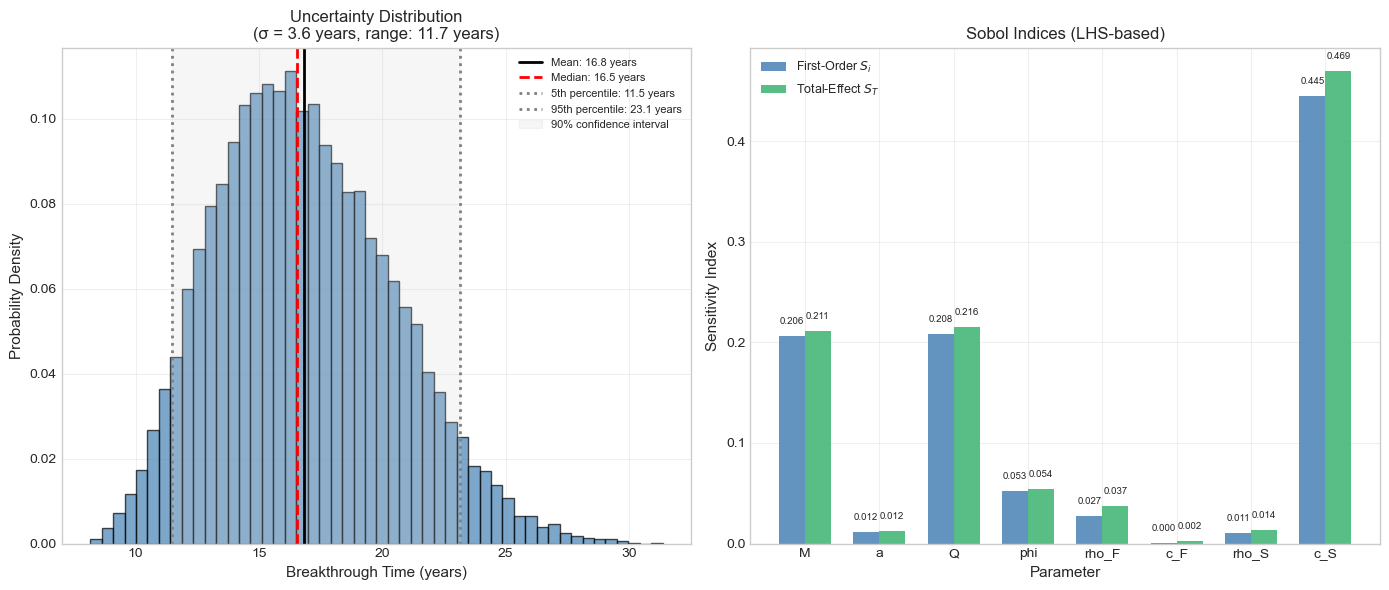

In [3]:
# Define parameters
param_names = ['M', 'a', 'Q', 'phi', 'rho_F', 'c_F', 'rho_S', 'c_S']  
num_params = len(param_names)

# Use first 8 parameters (without lambda_S) for breakthrough time analysis
bounds_bt = bounds[:8, :]
l_bounds = bounds_bt[:, 0]
u_bounds = bounds_bt[:, 1]

# Latin Hypercube Sampling (shared for Sobol + histogram)
N_base = 10000
sampler_A = qmc.LatinHypercube(d=num_params, seed=123)
sampler_B = qmc.LatinHypercube(d=num_params, seed=456)
A_unit = sampler_A.random(n=N_base)
B_unit = sampler_B.random(n=N_base)
A = qmc.scale(A_unit, l_bounds, u_bounds)
B = qmc.scale(B_unit, l_bounds, u_bounds)

# Breakthrough time model (vectorized)
def breakthrough_time(samples):
    M_s, a_s, Q_s, phi_s, rho_F_s, c_F_s, rho_S_s, c_S_s = samples.T
    rho_A_c_A_s = phi_s * rho_F_s * c_F_s + (1 - phi_s) * rho_S_s * c_S_s
    G_s = rho_A_c_A_s / (rho_F_s * c_F_s)
    return G_s * 4 * np.pi * M_s * a_s * a_s / (3 * Q_s) / SECONDS_PER_YEAR

# Evaluate base samples
yA = breakthrough_time(A)
yB = breakthrough_time(B)

# Variance for normalization (use combined samples for stability)
var_y = np.var(np.concatenate([yA, yB]), ddof=1)

# ============================================================
# Sobol Indices (LHS-based Saltelli pick-freeze)
# ============================================================
S_first = np.zeros(num_params)
S_total = np.zeros(num_params)

for i in range(num_params):
    ABi = A.copy()
    ABi[:, i] = B[:, i]
    yABi = breakthrough_time(ABi)
    # First-order Sobol index
    S_first[i] = np.mean(yB * (yABi - yA)) / var_y
    # Total-effect Sobol index
    S_total[i] = 0.5 * np.mean((yA - yABi) ** 2) / var_y

# Numerical safety
S_first = np.clip(S_first, 0, 1)
S_total = np.clip(S_total, 0, 1)

# ============================================================
# Histogram statistics (from the same LHS set)
# ============================================================
# Use both samples for more stable quantile estimates
breakthrough_times = np.concatenate([yA, yB])
tb_mean = np.mean(breakthrough_times)
tb_std = np.std(breakthrough_times)
tb_median = np.median(breakthrough_times)
tb_q05, tb_q95 = np.percentile(breakthrough_times, [5, 95])

# ============================================================
# Combined visualization (side-by-side)
# ============================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE_SUBPLOTS)

# Left: Histogram
counts, bins, patches = ax1.hist(breakthrough_times, bins=50, density=True,
                                 alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(tb_mean, color='black', linestyle='-', linewidth=2.0, label=f'Mean: {tb_mean:.1f} years')
ax1.axvline(tb_median, color='red', linestyle='--', linewidth=2, label=f'Median: {tb_median:.1f} years')
ax1.axvline(tb_q05, color='gray', linestyle=':', linewidth=2, label=f'5th percentile: {tb_q05:.1f} years')
ax1.axvline(tb_q95, color='gray', linestyle=':', linewidth=2, label=f'95th percentile: {tb_q95:.1f} years')
ax1.axvspan(tb_q05, tb_q95, alpha=0.2, color='lightgray', label='90% confidence interval')
ax1.set_xlabel('Breakthrough Time (years)', fontsize=11)
ax1.set_ylabel('Probability Density', fontsize=11)
ax1.set_title(f'Uncertainty Distribution\n(σ = {tb_std:.1f} years, range: {tb_q95-tb_q05:.1f} years)', fontsize=12)
ax1.legend(loc='best', fontsize=8)
ax1.grid(True, alpha=0.3)

# Right: Sobol indices
x = np.arange(num_params)
width = 0.35
ax2.bar(x - width / 2, S_first, width, label='First-Order $S_i$', alpha=0.85, color='steelblue')
ax2.bar(x + width / 2, S_total, width, label='Total-Effect $S_T$', alpha=0.85, color='mediumseagreen')
ax2.set_ylabel('Sensitivity Index', fontsize=11)
ax2.set_xlabel('Parameter', fontsize=11)
ax2.set_xticks(x)
ax2.set_xticklabels(param_names)
ax2.legend(fontsize=9)
ax2.set_title('Sobol Indices (LHS-based)', fontsize=12)
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for i in range(num_params):
    ax2.text(i - width / 2, S_first[i] + 0.01, f'{S_first[i]:.3f}', ha='center', va='bottom', fontsize=7)
    ax2.text(i + width / 2, S_total[i] + 0.01, f'{S_total[i]:.3f}', ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.show()

## Sensitivity analysis for breakthrough curve

This section quantifies uncertainty in the complete thermal breakthrough curve over time using Latin Hypercube Sampling (LHS), a quasi-random sampling method that ensures efficient coverage of the parameter space.

**Method: Latin Hypercube Sampling**
- More efficient than simple Monte Carlo sampling - better parameter space coverage with fewer samples
- Each parameter range is divided into N equally probable intervals, with one sample per interval
- Produces more stable and consistent uncertainty estimates

**Analysis outputs:**
- **Quantile bands**: Show the range of possible breakthrough curves
  - 50% quantile (25th-75th percentile): Where half of all realizations fall
  - 90% quantile (5th-95th percentile): Captures most of the uncertainty
- **Mean and Median curves**: Central tendency measures that help identify system behavior under average conditions

**Practical applications:**
- Evaluate worst-case and best-case scenarios for system thermal performance
- Assess whether design specifications can be met given parameter uncertainties
- Identify time periods where predictions are most uncertain
- Quantify risk for decision-making and system optimization


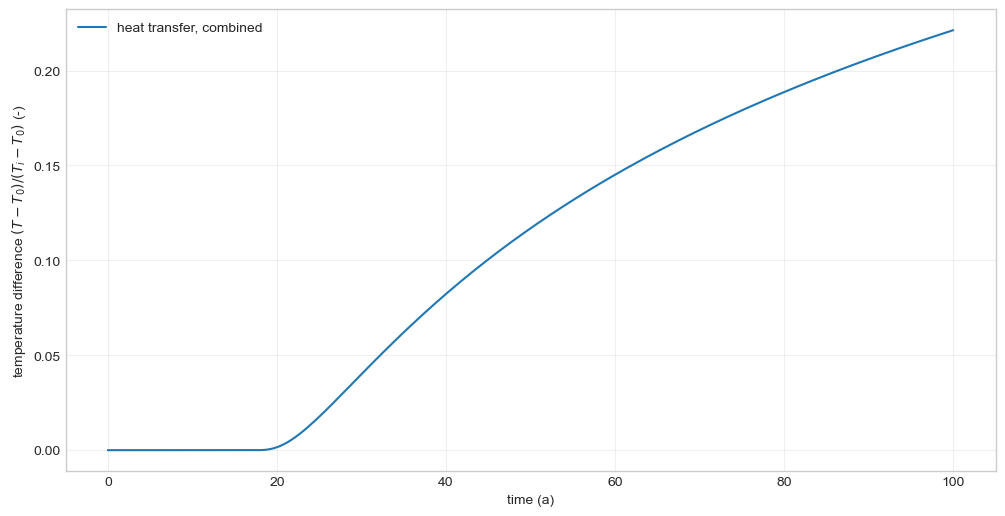

In [ ]:
def calculate_breakthrough_curve(time, M, a, Q, phi, rho_F, c_F, rho_S, c_S, lambda_S, 
                                  n_streamlines=360, epsilon=0.001):
    """
    Calculate the thermal breakthrough curve for a geothermal doublet system.
    
    Parameters:
    -----------
    time : array-like
        Time vector (years)
    M : float
        Thickness of the aquifer (m)
    a : float
        Half the distance between injection and extraction wells (m)
    Q : float
        Injection/extraction rate (m³/s)
    phi : float
        Porosity of the aquifer
    rho_F : float
        Fluid density (kg/m³)
    c_F : float
        Fluid heat capacity (J/kg/K)
    rho_S : float
        Density of the solid matrix (kg/m³)
    c_S : float
        Heat capacity of the solid matrix (J/kg/K)
    lambda_S : float
        Thermal conductivity (W/m/K)
    n_streamlines : int, optional
        Number of streamlines to calculate (default: 360)
    epsilon : float, optional
        Edge value offset to prevent division by zero (default: 0.001)
    
    Returns:
    --------
    T : array
        Temperature difference (T - T_0) / (T_i - T_0) over time
    """
    # Calculate derived parameters
    rho_A_c_A = phi * rho_F * c_F + (1 - phi) * rho_S * c_S
    G = rho_A_c_A / (rho_F * c_F)
    H = np.sqrt(lambda_S * rho_S * c_S) / (M * rho_F * c_F)
    
    # Calculate streamline arrival times using Charbeneau formula
    # Avoid edge values (0 and pi) to prevent division by zero
    phi1 = np.linspace(epsilon, np.pi - epsilon, n_streamlines)
    F = 1 - phi1 / np.pi
    
    # Calculate with valid values only
    sin_term = np.sin(np.pi * F)
    tan_term = np.tan(np.pi * F)
    
    # Filter out problematic values (where sin is close to zero)
    valid_mask = np.abs(sin_term) > 1e-10
    
    tf = np.zeros_like(phi1)
    tf[valid_mask] = (4 * np.pi * phi * M * a * a / Q * 
                      (1 - np.pi * F[valid_mask] / tan_term[valid_mask]) / 
                      (sin_term[valid_mask] ** 2) / SECONDS_PER_YEAR)
    
    tau2 = G * tf[valid_mask] / phi
    
    # Calculate temperature breakthrough curve
    T = np.zeros_like(time)
    for tau in tau2:
        U = np.heaviside(time - tau, 1)
        ind = U > 0
        if np.any(ind):
            abc = erfc(H * tau / G * np.sqrt(SECONDS_PER_YEAR) / np.sqrt(time[ind] - tau))
            T[ind] = T[ind] + U[ind] * abc
    
    T = T / len(tau2)
    return T


# Example calculation with fixed parameters
M_val = 30
a_val = 500
Q_val = 0.03
phi_val = 0.1
rho_F_val = 1100
c_F_val = 4200
rho_S_val = 2650
c_S_val = 750
lambda_S_val = 3.0

tmax = 50  # years
time = np.linspace(0, 2*tmax, 200)

T = calculate_breakthrough_curve(time, M_val, a_val, Q_val, phi_val, 
                                  rho_F_val, c_F_val, rho_S_val, c_S_val, lambda_S_val)

plt.figure(figsize=FIGSIZE_WIDE)
plt.plot(time, T, '-', label="heat transfer, combined")
plt.xlabel("time (a)")
plt.ylabel("temperature difference $(T - T_0) / (T_i - T_0)$ (-)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

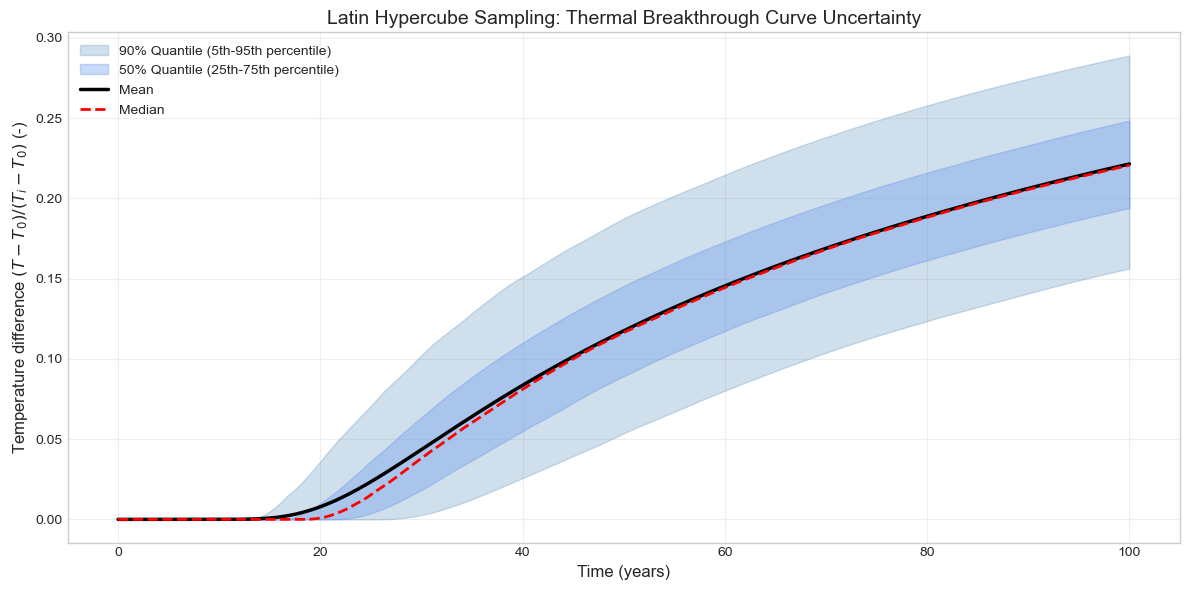

In [5]:
# Time vector
tmax = 50
t_vec = np.linspace(0, 2*tmax, 200)

# Latin Hypercube Sampling for better parameter space coverage
N = 1000
num_params_bc = bounds.shape[0]  # All 9 parameters including lambda_S

# Create Latin Hypercube sampler
sampler = qmc.LatinHypercube(d=num_params_bc, seed=42)
# Generate samples in [0, 1] space
lhs_samples = sampler.random(n=N)
# Scale samples to parameter bounds
l_bounds_bc = bounds[:, 0]
u_bounds_bc = bounds[:, 1]
param_samples = qmc.scale(lhs_samples, l_bounds_bc, u_bounds_bc)

# Evaluate all samples: Y_samples shape (N, len(t))
Y_samples = np.zeros((N, len(t_vec)))
for i, ps in enumerate(param_samples):
    Y_samples[i] = calculate_breakthrough_curve(t_vec, *ps)

# Compute statistics
y_mean = np.mean(Y_samples, axis=0)
y_median = np.median(Y_samples, axis=0)
y_q05, y_q25, y_q75, y_q95 = np.percentile(Y_samples, [5, 25, 75, 95], axis=0)

# Visualization
plt.figure(figsize=FIGSIZE_WIDE)

# Plot quantile bands
plt.fill_between(t_vec, y_q05, y_q95, alpha=0.25, color='steelblue', 
                 label='90% Quantile (5th-95th percentile)')
plt.fill_between(t_vec, y_q25, y_q75, alpha=0.35, color='cornflowerblue', 
                 label='50% Quantile (25th-75th percentile)')

# Plot mean and median
plt.plot(t_vec, y_mean, 'k-', linewidth=2.5, label='Mean')
plt.plot(t_vec, y_median, 'r--', linewidth=2, label='Median')

plt.xlabel('Time (years)', fontsize=12)
plt.ylabel('Temperature difference $(T - T_0) / (T_i - T_0)$ (-)', fontsize=12)
plt.title('Latin Hypercube Sampling: Thermal Breakthrough Curve Uncertainty', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()